In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import json
from os.path import expanduser
import sqlite3
import seaborn as sns

### detections

In [10]:
experiment_name = 'P3856'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'

EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(experiment_name)

FEATURES_PASEF_DIR = '{}/features-pasef'.format(EXPERIMENT_DIR)
FEATURES_PASEF_FILE = '{}/exp-{}-run-{}-features-pasef-dedup.pkl'.format(FEATURES_PASEF_DIR, experiment_name, run_name)

FEATURES_3DID_DIR = '{}/features-3did'.format(EXPERIMENT_DIR)
# FEATURES_3DID_FILE = '{}/exp-{}-run-{}-features-3did-dedup.pkl'.format(FEATURES_3DID_DIR, experiment_name, run_name)
FEATURES_3DID_FILE = '/media/big-ssd/results-P3856-3did/7-jul-minvi-5000/exp-{}-run-{}-features-3did-dedup.pkl'.format(experiment_name, run_name)

FEATURES_MQ_DIR = '{}/features-mq'.format(EXPERIMENT_DIR)
FEATURES_MQ_FILE = '{}/exp-{}-run-{}-features-mq-dedup.pkl'.format(FEATURES_MQ_DIR, experiment_name, run_name)

In [11]:
MAXIMUM_Q_VALUE = 0.01

In [12]:
# only look at this part of the run
RT_LOWER = 1650
RT_UPPER = 2200

In [13]:
# define a straight line to exclude the charge-1 cloud
def scan_coords_for_single_charge_region(mz_lower, mz_upper):
    scan_for_mz_lower = max(int(-1 * ((1.2 * mz_lower) - 1252)), 0)
    scan_for_mz_upper = max(int(-1 * ((1.2 * mz_upper) - 1252)), 0)
    return {'scan_for_mz_lower':scan_for_mz_lower, 'scan_for_mz_upper':scan_for_mz_upper}

#### PASEF-seeded

In [14]:
# load the features detected by PASEF
with open(FEATURES_PASEF_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_pasef_df = d['features_df']

In [15]:
features_pasef_df['excluded'] = features_pasef_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)

In [16]:
features_pasef_df = features_pasef_df[(features_pasef_df.excluded == False)]

#### 3DID

In [17]:
# load the features detected by 3DID
with open(FEATURES_3DID_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_3did_df = d['features_df']

#### MaxQuant

In [18]:
# load the features detected by MaxQuant
with open(FEATURES_MQ_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_mq_df = d['features_df']

In [19]:
features_mq_df['excluded'] = features_mq_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
features_mq_df = features_mq_df[(features_mq_df.excluded == False)]
features_mq_df = features_mq_df[(features_mq_df.rt_apex >= RT_LOWER) & (features_mq_df.rt_apex <= RT_UPPER)]
features_mq_df = features_mq_df[(features_mq_df.isotope_count >= 3)].copy()

In [20]:
print('{} features from PASEF, {} features from MaxQuant, {} features from 3DID'.format(len(features_pasef_df), len(features_mq_df), len(features_3did_df)))


70406 features from PASEF, 15437 features from MaxQuant, 30138 features from 3DID


#### consolidate the features from all methods

In [21]:
combined_names = ['feature_id','charge','monoisotopic_mz','scan_apex','rt_apex']

In [22]:
combined_features_mq_df = features_mq_df[combined_names].copy()
combined_features_mq_df['method'] = 'mq'

combined_features_pasef_df = features_pasef_df[combined_names].copy()
combined_features_pasef_df['method'] = 'pasef'

combined_features_3did_df = features_3did_df[combined_names].copy()
combined_features_3did_df['method'] = '3did'

combined_features_df = pd.concat([combined_features_mq_df,combined_features_pasef_df,combined_features_3did_df], axis=0, sort=False, ignore_index=True)
combined_features_df['method_feature_id'] = combined_features_df.method+'-'+combined_features_df.feature_id.astype('str')

#### find the features in common

In [23]:
DUP_MZ_TOLERANCE_PPM = 10
DUP_SCAN_TOLERANCE = 20
DUP_RT_TOLERANCE = 5

In [24]:
# set up dup definitions
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
combined_features_df['dup_mz'] = combined_features_df['monoisotopic_mz']  # shorthand to reduce verbosity
combined_features_df['dup_mz_ppm_tolerance'] = combined_features_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
combined_features_df['dup_mz_lower'] = combined_features_df.dup_mz - combined_features_df.dup_mz_ppm_tolerance
combined_features_df['dup_mz_upper'] = combined_features_df.dup_mz + combined_features_df.dup_mz_ppm_tolerance
combined_features_df['dup_scan_lower'] = combined_features_df.scan_apex - DUP_SCAN_TOLERANCE
combined_features_df['dup_scan_upper'] = combined_features_df.scan_apex + DUP_SCAN_TOLERANCE
combined_features_df['dup_rt_lower'] = combined_features_df.rt_apex - DUP_RT_TOLERANCE
combined_features_df['dup_rt_upper'] = combined_features_df.rt_apex + DUP_RT_TOLERANCE

In [25]:
combined_id = 1
sets_d = {'mq':set(), '3did':set(), 'pasef':set()}
features_processed = set()
for row in combined_features_df.itertuples():
    if row.method_feature_id not in features_processed:
        df = combined_features_df[(row.charge == combined_features_df.charge) & (row.dup_mz >= combined_features_df.dup_mz_lower) & (row.dup_mz <= combined_features_df.dup_mz_upper) & (row.scan_apex >= combined_features_df.dup_scan_lower) & (row.scan_apex <= combined_features_df.dup_scan_upper) & (row.rt_apex >= combined_features_df.dup_rt_lower) & (row.rt_apex <= combined_features_df.dup_rt_upper)].copy()
        if len(df) > 0:
            # remove the features that have already been processed
            feature_ids_not_processed = set(df.method_feature_id.tolist()) - features_processed
            df = df[(df.method_feature_id.isin(feature_ids_not_processed))]
            for method in df.method.tolist():
                sets_d[method].add(combined_id)
            # record the features that have been processed
            features_processed.update(set(df.method_feature_id.tolist()))
            combined_id += 1

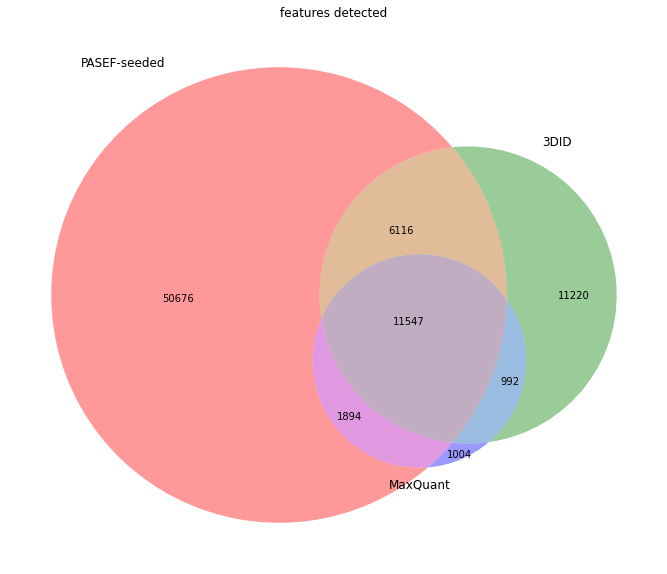

In [26]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

f, ax1 = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('features detected')

venn3([sets_d['pasef'],sets_d['3did'],sets_d['mq']], ('PASEF-seeded','3DID','MaxQuant'))

plt.show()

### identifications

#### PASEF-seeded

In [27]:
IDENTS_PASEF_DIR = '{}/identifications-pasef'.format(EXPERIMENT_DIR)
IDENTS_PASEF_FILE = '{}/exp-{}-identifications-pasef-recalibrated.pkl'.format(IDENTS_PASEF_DIR, experiment_name)

In [28]:
# load the features identified by PASEF
with open(IDENTS_PASEF_FILE, 'rb') as handle:
    d = pickle.load(handle)
idents_pasef_df = d['identifications_df']
idents_pasef_df = idents_pasef_df[(idents_pasef_df.run_name == run_name) & (idents_pasef_df['percolator q-value'] <= MAXIMUM_Q_VALUE)].copy()

In [29]:
idents_pasef_df['excluded'] = idents_pasef_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
idents_pasef_df = idents_pasef_df[(idents_pasef_df.excluded == False)]

#### MaxQuant

In [30]:
MQ_PERCOLATOR_OUTPUT_DIR = '{}/percolator-output-pasef-maxquant'.format(EXPERIMENT_DIR)

In [31]:
# load the percolator output
MQ_PERCOLATOR_OUTPUT_FILE_NAME = "{}/{}.percolator.target.psms.txt".format(MQ_PERCOLATOR_OUTPUT_DIR, experiment_name)
mq_psms_df = pd.read_csv(MQ_PERCOLATOR_OUTPUT_FILE_NAME, sep='\t')
mq_psms_df.rename(columns={'scan': 'mq_index'}, inplace=True)
mq_psms_df.drop(['charge'], axis=1, inplace=True)
# remove the poor quality identifications
mq_psms_df = mq_psms_df[mq_psms_df['peptide mass'] > 0]

In [32]:
idents_mq_df = pd.merge(features_mq_df, mq_psms_df, how='left', left_on=['mq_index'], right_on=['mq_index'])
# remove any features that were not identified
idents_mq_df.dropna(subset=['sequence'], inplace=True)

In [33]:
idents_mq_df = idents_mq_df[(idents_mq_df.raw_file == run_name) & (idents_mq_df['percolator q-value'] <= MAXIMUM_Q_VALUE)].copy()

In [34]:
idents_mq_df['excluded'] = idents_mq_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
idents_mq_df = idents_mq_df[(idents_mq_df.excluded == False)]
idents_mq_df = idents_mq_df[(idents_mq_df.rt_apex >= RT_LOWER) & (idents_mq_df.rt_apex <= RT_UPPER)]
idents_mq_df['feature_intensity'] = idents_mq_df.intensity
idents_mq_df = idents_mq_df[(idents_mq_df.isotope_count >= 3)].copy()

#### consolidate the identifications from all methods

In [35]:
combined_names = ['feature_id','charge','monoisotopic_mz','scan_apex','rt_apex']

In [36]:
combined_idents_mq_df = idents_mq_df[combined_names].copy()
combined_idents_mq_df['method'] = 'mq'

combined_idents_pasef_df = idents_pasef_df[combined_names].copy()
combined_idents_pasef_df['method'] = 'pasef'

combined_idents_3did_df = features_3did_df[combined_names].copy()
combined_idents_3did_df['method'] = '3did'

combined_idents_df = pd.concat([combined_idents_mq_df,combined_idents_pasef_df,combined_idents_3did_df], axis=0, sort=False, ignore_index=True)
combined_idents_df['method_feature_id'] = combined_idents_df.method+'-'+combined_idents_df.feature_id.astype('str')

#### find the identifications in common

In [37]:
# set up dup definitions
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
combined_idents_df['dup_mz'] = combined_idents_df['monoisotopic_mz']  # shorthand to reduce verbosity
combined_idents_df['dup_mz_ppm_tolerance'] = combined_idents_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
combined_idents_df['dup_mz_lower'] = combined_idents_df.dup_mz - combined_idents_df.dup_mz_ppm_tolerance
combined_idents_df['dup_mz_upper'] = combined_idents_df.dup_mz + combined_idents_df.dup_mz_ppm_tolerance
combined_idents_df['dup_scan_lower'] = combined_idents_df.scan_apex - DUP_SCAN_TOLERANCE
combined_idents_df['dup_scan_upper'] = combined_idents_df.scan_apex + DUP_SCAN_TOLERANCE
combined_idents_df['dup_rt_lower'] = combined_idents_df.rt_apex - DUP_RT_TOLERANCE
combined_idents_df['dup_rt_upper'] = combined_idents_df.rt_apex + DUP_RT_TOLERANCE

In [38]:
combined_id = 1
combined_features = []
sets_d = {'mq':set(), '3did':set(), 'pasef':set()}
features_processed = set()
for row in combined_idents_df.itertuples():
    if row.method_feature_id not in features_processed:
        df = combined_idents_df[(row.charge == combined_idents_df.charge) & (row.dup_mz >= combined_idents_df.dup_mz_lower) & (row.dup_mz <= combined_idents_df.dup_mz_upper) & (row.scan_apex >= combined_idents_df.dup_scan_lower) & (row.scan_apex <= combined_idents_df.dup_scan_upper) & (row.rt_apex >= combined_idents_df.dup_rt_lower) & (row.rt_apex <= combined_idents_df.dup_rt_upper)].copy()
        if len(df) > 0:
            # remove the features that have already been processed
            feature_ids_not_processed = set(df.method_feature_id.tolist()) - features_processed
            df = df[(df.method_feature_id.isin(feature_ids_not_processed))]
            for method in df.method.tolist():
                sets_d[method].add(combined_id)
            # record the features that have been processed
            features_processed.update(set(df.method_feature_id.tolist()))
            # separate the method feature ids
            feature_ids = {'3did':0, 'pasef':0, 'mq':0}
            for m in df.method_feature_id.tolist():
                method = m.split('-')[0]
                feature_id = int(m.split('-')[1])
                feature_ids[method] = feature_id
            # store the features that were combined
            combined_features.append({'combined_id':combined_id, 'number_of_methods':len(df.method.unique()), 'methods':list(df.method.unique()), 'method_ids':df.method_feature_id.tolist(), '3did_feature_id':feature_ids['3did'], 'pasef_feature_id':feature_ids['pasef'], 'mq_feature_id':feature_ids['mq']})
            # update the combined feature identifier
            combined_id += 1

In [39]:
combined_features_df = pd.DataFrame(combined_features)
combined_features_df.to_pickle('{}/combined_features_df.pkl'.format(expanduser('~')))

In [40]:
combined_features_df.sample(n=5)

,combined_id,number_of_methods,methods,method_ids,3did_feature_id,pasef_feature_id,mq_feature_id
181,182,1,[mq],[mq-1226073],0,0,1226073
10782,10783,1,[3did],[3did-13245],13245,0,0
18584,18585,1,[3did],[3did-22772],22772,0,0
27153,27154,1,[3did],[3did-19460],19460,0,0
29781,29782,1,[3did],[3did-47789],47789,0,0


In [41]:
# merge 3DID attributes
combined_features_df = pd.merge(combined_features_df, features_3did_df[['feature_id','prediction','deconvolution_score','feature_intensity']], how='left', left_on=['3did_feature_id'], right_on=['feature_id'])
combined_features_df.rename(columns={'prediction':'3did_prediction', 'deconvolution_score':'3did_deconvolution_score', 'feature_intensity':'3did_feature_intensity'}, inplace=True)
combined_features_df.drop(['feature_id'], axis=1, inplace=True)

In [42]:
# merge PASEF attributes
combined_features_df = pd.merge(combined_features_df, idents_pasef_df[['feature_id','deconvolution_score','feature_intensity']], how='left', left_on=['pasef_feature_id'], right_on=['feature_id'])
combined_features_df.rename(columns={'deconvolution_score':'pasef_deconvolution_score', 'feature_intensity':'pasef_feature_intensity'}, inplace=True)
combined_features_df.drop(['feature_id'], axis=1, inplace=True)

In [43]:
# merge MQ attributes
combined_features_df = pd.merge(combined_features_df, idents_mq_df[['feature_id','feature_intensity']], how='left', left_on=['mq_feature_id'], right_on=['feature_id'])
combined_features_df.rename(columns={'feature_intensity':'mq_feature_intensity'}, inplace=True)
combined_features_df.drop(['feature_id'], axis=1, inplace=True)

In [44]:
combined_features_df['3did_log_intensity'] = np.log10(combined_features_df['3did_feature_intensity'])
combined_features_df['pasef_log_intensity'] = np.log10(combined_features_df.pasef_feature_intensity)
combined_features_df['mq_log_intensity'] = np.log10(combined_features_df.mq_feature_intensity)

In [45]:
combined_features_df.fillna(0, inplace=True)

In [46]:
combined_features_df.sample(n=3)

,combined_id,number_of_methods,methods,method_ids,3did_feature_id,pasef_feature_id,mq_feature_id,3did_prediction,3did_deconvolution_score,3did_feature_intensity,pasef_deconvolution_score,pasef_feature_intensity,mq_feature_intensity,3did_log_intensity,pasef_log_intensity,mq_log_intensity
13407,13408,1,[3did],[3did-10110],10110,0,0,0.890486,1974.304691,36597,0.0,0.0,0.0,4.563445,0.0,0.0
18322,18323,1,[3did],[3did-28298],28298,0,0,0.850642,380.734654,2071,0.0,0.0,0.0,3.316180,0.0,0.0
12531,12532,1,[3did],[3did-54029],54029,0,0,0.899116,773.998844,5562,0.0,0.0,0.0,3.745231,0.0,0.0


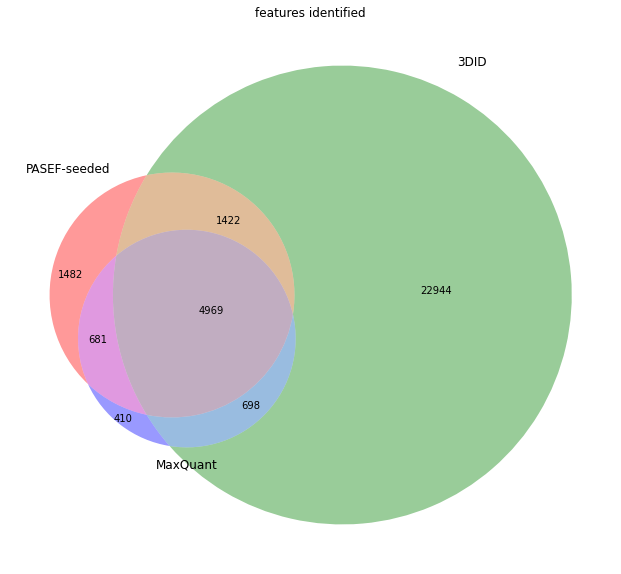

In [47]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

f, ax1 = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('features identified')

venn3([sets_d['pasef'],sets_d['3did'],sets_d['mq']], ('PASEF-seeded','3DID','MaxQuant'))

plt.show()

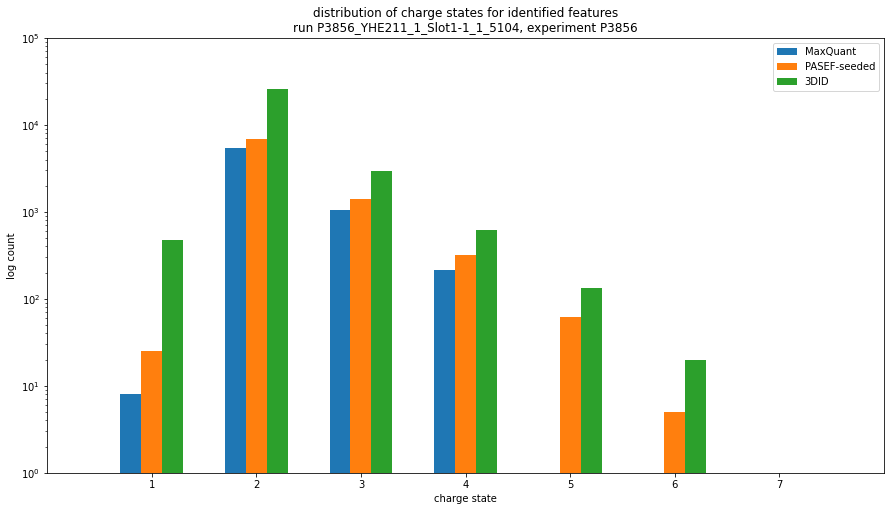

In [48]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

barwidth = 0.2
max_charge = max(idents_mq_df.charge.max(), idents_pasef_df.charge.max(), features_3did_df.charge.max())

pos1 = [x - barwidth for x in range(max_charge+1)]
pos2 = [x + barwidth for x in pos1]
pos3 = [x + (2*barwidth) for x in pos1]

counts = np.bincount(idents_mq_df.charge, minlength=max_charge+1)
ax1.bar(pos1, counts, width=barwidth, align='center', log=True, label='MaxQuant')

counts = np.bincount(idents_pasef_df.charge, minlength=max_charge+1)
ax1.bar(pos2, counts, width=barwidth, align='center', log=True, label='PASEF-seeded')

counts = np.bincount(features_3did_df.charge, minlength=max_charge+1)
ax1.bar(pos3, counts, width=barwidth, align='center', log=True, label='3DID')

ax1.set(xticks=range(1,max_charge+1), xlim=[0, max_charge+1])

plt.xlabel('charge state')
plt.ylabel('log count')
plt.title('distribution of charge states for identified features\nrun {}, experiment {}'.format(run_name, experiment_name))

plt.ylim((1,10**5))

plt.legend()
plt.show()

In [49]:
pasef_3did_df = combined_features_df[(combined_features_df.pasef_feature_id > 0) & (combined_features_df['3did_feature_id'] > 0)]

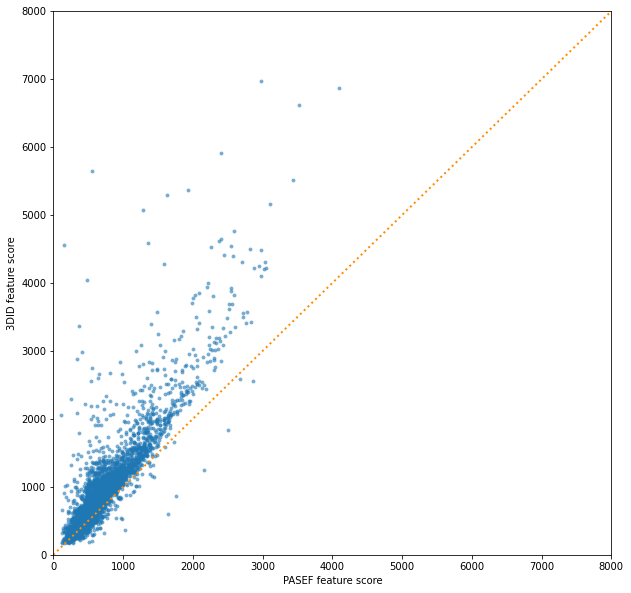

In [50]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

plt.margins(0.06)
# plt.title('deconvolution score for features identified by PASEF-seeded and features detected by 3DID methods')

ax.scatter(pasef_3did_df.pasef_deconvolution_score, pasef_3did_df['3did_deconvolution_score'], marker='o', lw=0, s=15, alpha=0.6)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=':', linewidth=2, color='darkorange')

plt.xlim((-1,8000))
plt.ylim((-1,8000))

plt.xlabel('PASEF feature score')
plt.ylabel('3DID feature score')

plt.show()

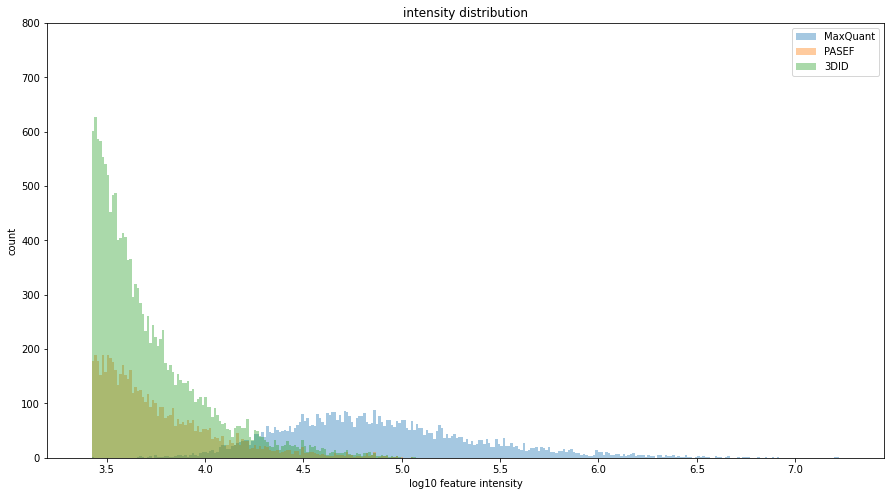

In [51]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('intensity distribution')

bins = 300
hist, bins, _ = plt.hist(combined_features_df[combined_features_df.mq_feature_id > 0].mq_log_intensity, bins=bins, alpha=0.4, label='MaxQuant')
hist, bins, _ = plt.hist(combined_features_df[combined_features_df.pasef_feature_id > 0].pasef_log_intensity, bins=bins, alpha=0.4, label='PASEF')
hist, bins, _ = plt.hist(combined_features_df[combined_features_df['3did_feature_id'] > 0]['3did_log_intensity'], bins=bins, alpha=0.4, label='3DID')

plt.xlabel('log10 feature intensity')
plt.ylabel('count')

# plt.xlim((0,8))
plt.ylim((0,800))

plt.legend()
plt.show()

In [52]:
unique_mq_df = combined_features_df[(combined_features_df.mq_feature_id > 0) & (combined_features_df.pasef_feature_id == 0) & (combined_features_df['3did_feature_id'] == 0)]
unique_pasef_df = combined_features_df[(combined_features_df.mq_feature_id == 0) & (combined_features_df.pasef_feature_id > 0) & (combined_features_df['3did_feature_id'] == 0)]
unique_3did_df = combined_features_df[(combined_features_df.mq_feature_id == 0) & (combined_features_df.pasef_feature_id == 0) & (combined_features_df['3did_feature_id'] > 0)]


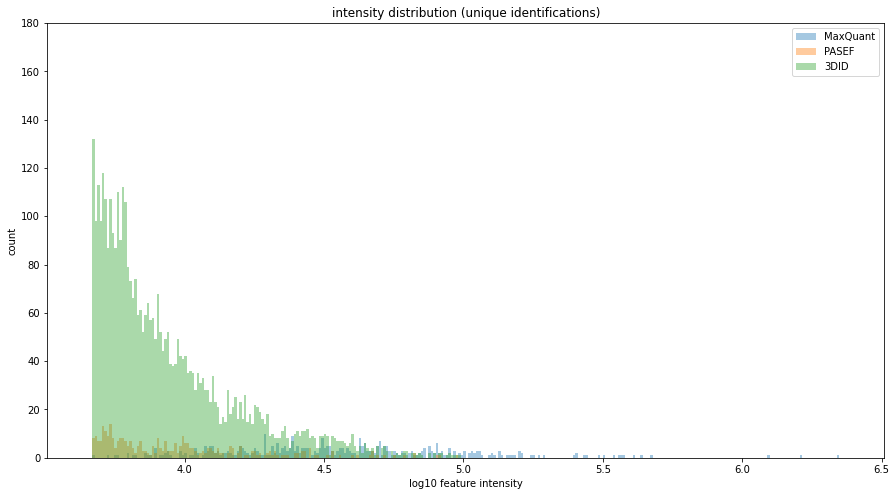

In [53]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('intensity distribution (unique identifications)')

bins = 300
hist, bins, _ = plt.hist(unique_mq_df.mq_log_intensity, bins=bins, alpha=0.4, label='MaxQuant')
hist, bins, _ = plt.hist(unique_pasef_df.pasef_log_intensity, bins=bins, alpha=0.4, label='PASEF')
hist, bins, _ = plt.hist(unique_3did_df['3did_log_intensity'], bins=bins, alpha=0.4, label='3DID')

plt.xlabel('log10 feature intensity')
plt.ylabel('count')

# plt.xlim((0,8))
plt.ylim((0,180))

plt.legend()
plt.show()